In [1]:
from sklearn.datasets import fetch_california_housing

housing_data = fetch_california_housing()

descr = housing_data['DESCR']
feature_names = housing_data['feature_names']
data = housing_data['data']
target = housing_data['target']

The data set you just imported is the california housing data set. Run the code line below for a short documentation.

In [2]:
print(descr)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

Before we begin, use the following cell to perform all your imports. You can use any package you choose to as long as it can be installed via pip or conda install.

In [32]:
## write all of your imports here
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import numpy as np 
from typing import Dict
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import warnings
warnings.filterwarnings('ignore')

In [4]:
med_inc_column_name = 'MedInc'
house_age_column_name = 'HouseAge'      
ave_rooms_column_name = 'AveRooms'      
ave_bed_rms_column_name = 'AveBedrms'     
population_column_name = 'Population'   
ave_occup_column_name = 'AveOccup'     
latitude_column_name = 'Latitude'     
longitude_column_name = 'Longitude'
target_column_name = 'target'

In [5]:
random_seed = 42
test_percentage = 0.2
validation_percentage = 0.1

Your task is to create a prediction engine that will predict the median house price for a district based on its features. Please follow the steps as detailed below.
### Split your data
Let's start simple.
Please write a function below to split your data into train, validation and test sets. Adhere to the inputs and outputs as defined in the code.

In [6]:
def trainValidTestSplit(X, y):
    
    non_train_percentage = test_percentage + validation_percentage
    
    X_train, X_test_and_validatio, y_train, y_test_and_validation = train_test_split(X, y, test_size=non_train_percentage, random_state=random_seed)
    
    
    
    X_test, X_validation, y_test, y_validation = train_test_split(X_test_and_validatio, y_test_and_validation, test_size=validation_percentage/(test_percentage + validation_percentage), random_state=random_seed)
    
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

Run your function here:

In [7]:
# Do not change this code
X_train, X_valid, X_test, y_train, y_valid, y_test = trainValidTestSplit(data, target)

In [8]:
train_df = pd.DataFrame(data= X_train, columns=housing_data.feature_names)
train_df[target_column_name] = y_train

test_df = pd.DataFrame(data= X_test, columns=housing_data.feature_names)
test_df[target_column_name] = y_test

validation_df = pd.DataFrame(data= X_valid, columns=housing_data.feature_names)
validation_df[target_column_name] = y_valid

## Data exploration
Get to know your data. Use the following cell to show us how you get acquainted with new data and start a new project. you can feel free to add a few cells if needed. In this section you can use scripts as this code does not need to be reusable.

Please add clear documentation to help us understand your process.

In [9]:
CORRELATIONS_COLUMNS = [med_inc_column_name, house_age_column_name, ave_rooms_column_name,ave_bed_rms_column_name, population_column_name,ave_occup_column_name, target_column_name]

In [10]:
train_df.sample(4)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
4057,4.0924,19.0,5.942222,1.048889,744.0,3.306667,38.17,-121.28,2.442
918,2.5703,45.0,4.874251,1.053892,754.0,2.257485,35.42,-119.03,0.624
7431,5.2590,36.0,5.912234,0.957447,1162.0,3.090426,33.86,-118.34,2.794
7900,3.2188,33.0,5.664430,1.050336,808.0,2.711409,34.05,-117.19,1.178


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14447 entries, 0 to 14446
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      14447 non-null  float64
 1   HouseAge    14447 non-null  float64
 2   AveRooms    14447 non-null  float64
 3   AveBedrms   14447 non-null  float64
 4   Population  14447 non-null  float64
 5   AveOccup    14447 non-null  float64
 6   Latitude    14447 non-null  float64
 7   Longitude   14447 non-null  float64
 8   target      14447 non-null  float64
dtypes: float64(9)
memory usage: 1015.9 KB


In [12]:
train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,3.876874,28.574929,5.438094,1.098042,1427.941856,3.119246,35.650788,-119.584211,2.069249
std,1.904973,12.613957,2.453651,0.447512,1140.263316,12.374064,2.135768,2.002957,1.157532
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.692308,32.550000,-124.350000,0.149990
25%,2.567150,18.000000,4.448921,1.006793,791.000000,2.430380,33.940000,-121.800000,1.193000
50%,3.539100,29.000000,5.232389,1.049505,1168.000000,2.817073,34.270000,-118.510000,1.793000
75%,4.758350,37.000000,6.060704,1.100332,1727.000000,3.279200,37.720000,-118.010000,2.646000
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [13]:
train_df[CORRELATIONS_COLUMNS].corr(method='pearson')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,target
MedInc,1.000000,-0.117512,0.323253,-0.071108,0.003662,0.024554,0.688231
HouseAge,-0.117512,1.000000,-0.157537,-0.087342,-0.291585,0.017438,0.106554
AveRooms,0.323253,-0.157537,1.000000,0.845550,-0.075527,-0.004659,0.152108
AveBedrms,-0.071108,-0.087342,0.845550,1.000000,-0.071978,-0.005809,-0.048458
Population,0.003662,-0.291585,-0.075527,-0.071978,1.000000,0.075018,-0.024318
AveOccup,0.024554,0.017438,-0.004659,-0.005809,0.075018,1.000000,-0.020960
target,0.688231,0.106554,0.152108,-0.048458,-0.024318,-0.020960,1.000000


In [14]:
train_df[CORRELATIONS_COLUMNS].corr(method='kendall')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,target
MedInc,1.000000,-0.097929,0.468013,-0.171319,0.002735,-0.023213,0.495633
HouseAge,-0.097929,1.000000,-0.157743,-0.082166,-0.197211,-0.014744,0.050146
AveRooms,0.468013,-0.157743,1.000000,0.058706,-0.073915,0.020704,0.174495
AveBedrms,-0.171319,-0.082166,0.058706,1.000000,0.019258,-0.089512,-0.084631
Population,0.002735,-0.197211,-0.073915,0.019258,1.000000,0.160363,0.002887
AveOccup,-0.023213,-0.014744,0.020704,-0.089512,0.160363,1.000000,-0.174620
target,0.495633,0.050146,0.174495,-0.084631,0.002887,-0.174620,1.000000


## Visualization
Now it is time to present your initial understanding of the data to the product team. Please write a class for data presentation. You might want to use these visualization in other projects. Make sure nothing is hard coded and this is a generic class that run on any data table (and target) you feed into it. Write a seperate function for each visualization.

In [16]:
PEARSON = "pearson"
KENDALL = "kendall"
SPEARMAN = "spearman"
POPULATION_MAGNITUDE = "Population Magnitude"
POPULATION = "Population"

In [46]:
class Visualization:
    
    CORRELATIONS_METHODS = {PEARSON, KENDALL, SPEARMAN} 
    
    def __init__(self, df):
        
        self._df = df
    
            
    def plot_correlation(self, method, columns = None):
        if not method or method not in Visualization.CORRELATIONS_METHODS:
            raise Exception("method must be one of {}".format(', '.join(Visualization.CORRELATIONS_METHODS)))
            
        df = self._df[columns] if columns is not None else self._df
        
        print(df.corr(method=method).to_string())
    
    def hist(self, x_column, label = None, color = 'red', ax = None, bins = None):
        
        target_bins = bins if bins is not None else np.histogram_bin_edges(a = self._df[x_column],
                                                                          bins = 'auto')
        target_label = label if label else x_column
        sns.histplot(data=self._df, x=x_column, color=color, label=target_label, kde=True, ax=ax,
                    bins = target_bins)
    
    def plot_locations(self, lat_column_name: str, lon_column_name: str,  population_column_name: str,
                       plt_label: str, plt_title: str):
        
        plt.figure(figsize=(18,10))
        plt.scatter(self._df[lat_column_name],self._df[lon_column_name],c= self._df[population_column_name], cmap='cool', alpha = 0.8)
        plt.colorbar().set_label(plt_label)
        plt.title(plt_title)
        plt.xlabel(latitude_column_name)
        plt.ylabel(longitude_column_name)
        plt.show()
    
    def scatter_matrix(self, columns, alpha = 0.2, figsize=(17, 17), diagonal = 'hist' ):
        df = self._df[columns] if columns is not None else self._df
        pd.plotting.scatter_matrix(df, alpha = alpha, figsize= figsize, diagonal = diagonal)
        
    def plot_predictions(self, predictions_df: pd.DataFrame, x_column: str, y_column: str, dataets_column: str):
        
        sns.relplot(
            data=predictions_df, x=x_column, y=y_column,
            col=dataets_column,
            kind="scatter"
        )


            

In [47]:
visualizer = Visualization(train_df)

In [19]:
visualizer.plot_correlation(PEARSON, CORRELATIONS_COLUMNS)

              MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup    target
MedInc      1.000000 -0.117512  0.323253  -0.071108    0.003662  0.024554  0.688231
HouseAge   -0.117512  1.000000 -0.157537  -0.087342   -0.291585  0.017438  0.106554
AveRooms    0.323253 -0.157537  1.000000   0.845550   -0.075527 -0.004659  0.152108
AveBedrms  -0.071108 -0.087342  0.845550   1.000000   -0.071978 -0.005809 -0.048458
Population  0.003662 -0.291585 -0.075527  -0.071978    1.000000  0.075018 -0.024318
AveOccup    0.024554  0.017438 -0.004659  -0.005809    0.075018  1.000000 -0.020960
target      0.688231  0.106554  0.152108  -0.048458   -0.024318 -0.020960  1.000000


In [20]:
visualizer.plot_correlation(KENDALL, CORRELATIONS_COLUMNS)

              MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup    target
MedInc      1.000000 -0.097929  0.468013  -0.171319    0.002735 -0.023213  0.495633
HouseAge   -0.097929  1.000000 -0.157743  -0.082166   -0.197211 -0.014744  0.050146
AveRooms    0.468013 -0.157743  1.000000   0.058706   -0.073915  0.020704  0.174495
AveBedrms  -0.171319 -0.082166  0.058706   1.000000    0.019258 -0.089512 -0.084631
Population  0.002735 -0.197211 -0.073915   0.019258    1.000000  0.160363  0.002887
AveOccup   -0.023213 -0.014744  0.020704  -0.089512    0.160363  1.000000 -0.174620
target      0.495633  0.050146  0.174495  -0.084631    0.002887 -0.174620  1.000000


Use the next cell to run all the functions you have just created. If it is not self explainatory, please add an explanation.

No handles with labels found to put in legend.


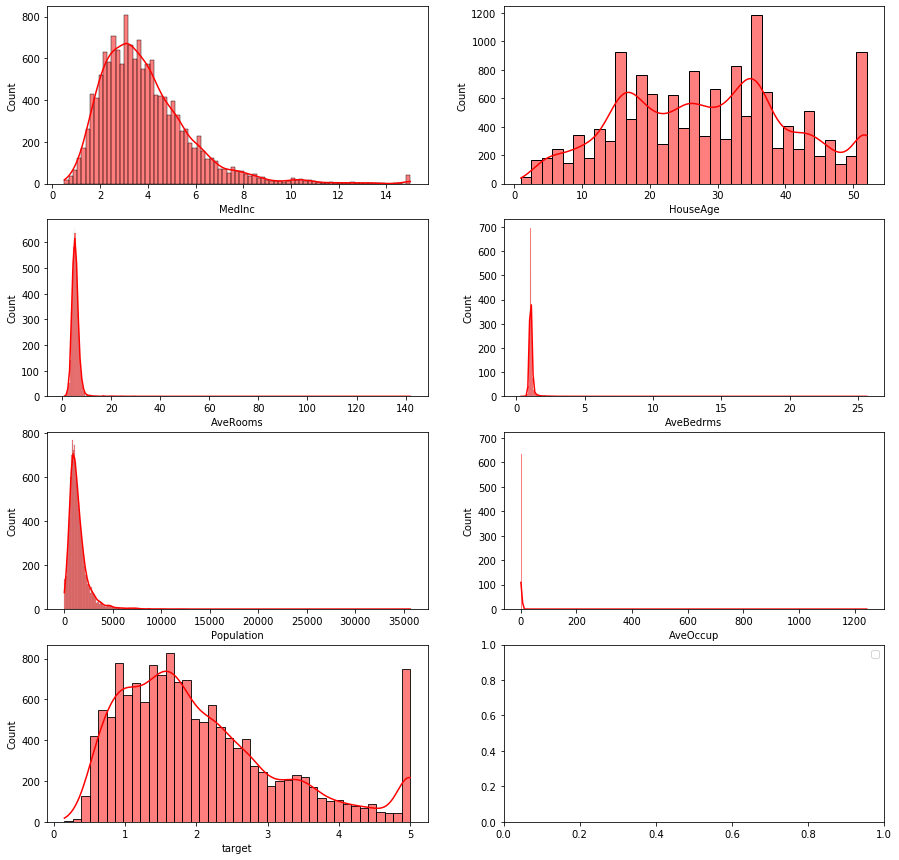

In [21]:
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

visualizer.hist(med_inc_column_name, ax = axs[0, 0])
visualizer.hist(house_age_column_name, ax=axs[0, 1])
visualizer.hist(ave_rooms_column_name, ax=axs[1, 0])

visualizer.hist(ave_bed_rms_column_name, ax=axs[1, 1])
visualizer.hist(population_column_name, ax=axs[2, 0])
visualizer.hist(ave_occup_column_name, ax=axs[2, 1])
visualizer.hist(target_column_name, ax=axs[3, 0])

plt.legend() 
plt.show()

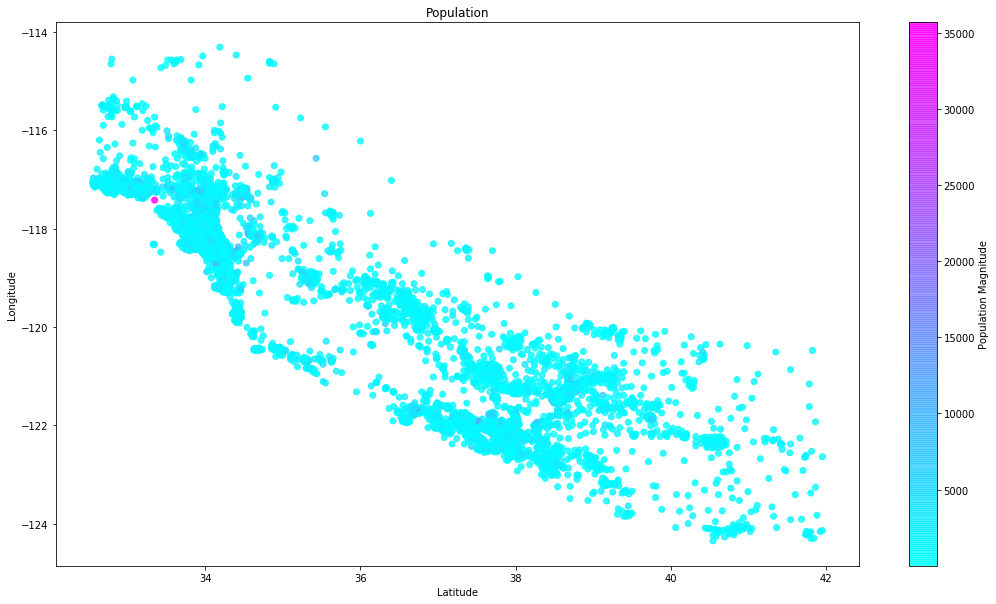

In [22]:
visualizer.plot_locations(latitude_column_name, longitude_column_name, population_column_name,
                         POPULATION_MAGNITUDE, POPULATION)

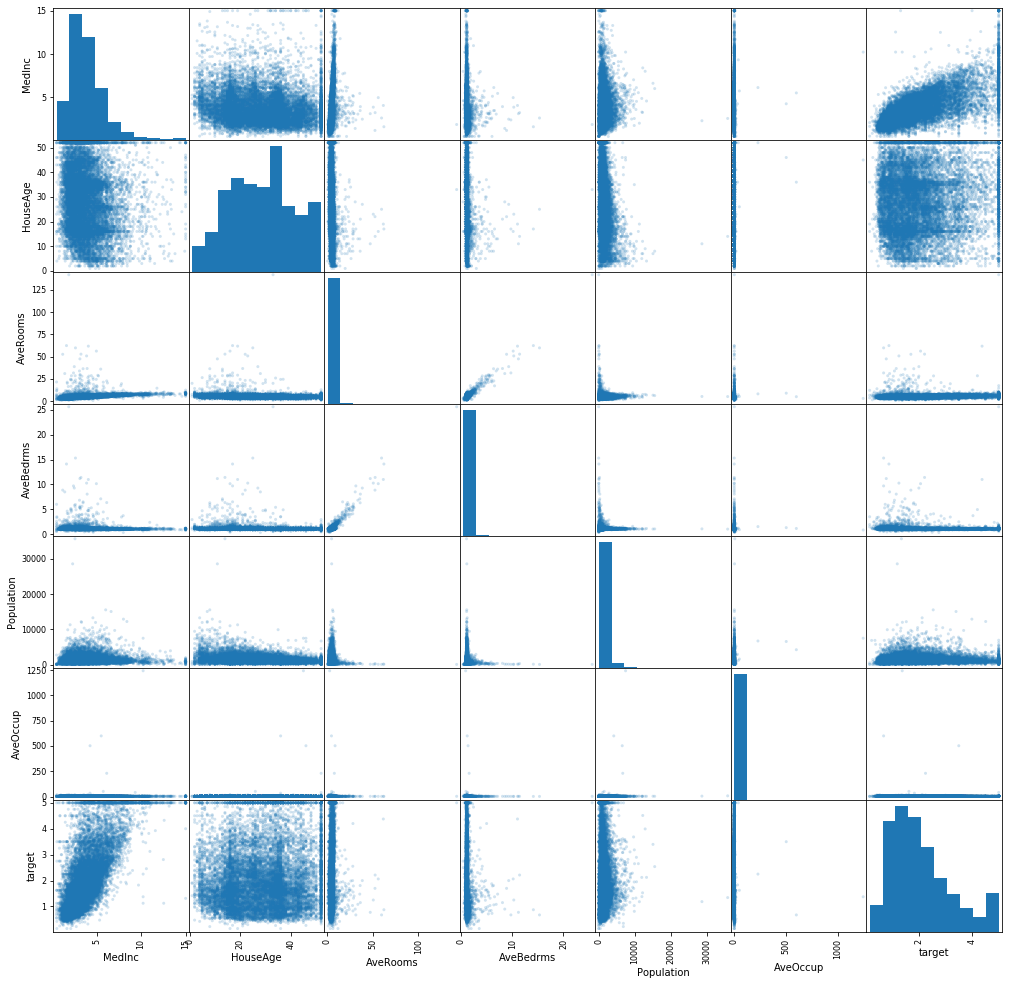

In [23]:
visualizer.scatter_matrix(CORRELATIONS_COLUMNS)

## Preprocessing
Please write a class that performs all the preprocessing needed before you start creating your predictive model. 
Normally, we would break this process into multiple classes, but as this is a limited task, you can write a single class the performs all the tasks (e.g. feature engineering, normalization, feature selection, etc.).

In [24]:
med_in_percentiles = range(10, 110, 10)

In [25]:
med_inc_percentile_column_name = 'med_inc_percentile'
latitude_one_decimal_digit_column_name = 'latitude_one_decimal_digit'
longitude_one_decimal_digit_column_name = 'longitude_one_decimal_digit'

In [26]:
class Preprocessor():
    
    POINT = "."
    def __init__(self, df):
        
        self._df = df
    
    def _round(self, value, number_of_decimal_digits):
        value_str = str(value)
        point_index = value_str.index(Preprocessor.POINT)
         
        if len(value_str[point_index +1:]) > number_of_decimal_digits:
            rounded_value = float(value_str[0: point_index + number_of_decimal_digits +1])
        else:
            rounded_value = value
        
        return rounded_value

    def set_round_location(self, source_column_to_dest_column: Dict[str, str], number_of_decimal_digits: int):
        for source_column, dest_column in source_column_to_dest_column.items():
            self._df[dest_column] = self._df[source_column].apply(lambda value: self._round(value, number_of_decimal_digits))
    
    def _get_value_percentile(self, value, percentiles_values):
        found = None
        for i in range(len(percentiles_values)):
            if percentiles_values[i] > value:
                found =  i
                break

        found = found if found is not None else len(percentiles_values)-1
        return found if found is not None else len(percentiles_values) - 1
        
    def set_percentile(self, source_column: str, percentiles, dest_column: str):
        percentiles_values = np.percentile(train_df[source_column].tolist(), percentiles)
        
        self._df[dest_column] = self._df[source_column].apply(lambda value: self._get_value_percentile(value, percentiles_values))       


Run your preprocessing class in the next cell

In [27]:
# Process your data here

def calcifornia_housing_preprocessing(df: pd.DataFrame):
    preprocessor = Preprocessor(df)
    preprocessor.set_round_location({latitude_column_name: latitude_one_decimal_digit_column_name, longitude_column_name: longitude_one_decimal_digit_column_name}, 1)
    
    preprocessor.set_percentile(med_inc_column_name, med_in_percentiles, med_inc_percentile_column_name)
    
    return df

train_df = calcifornia_housing_preprocessing(train_df)
test_df = calcifornia_housing_preprocessing(test_df)
validation_df = calcifornia_housing_preprocessing(validation_df)

In [28]:
test_df.sample(1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,latitude_one_decimal_digit,longitude_one_decimal_digit,med_inc_percentile
2910,2.1864,17.0,5.818444,1.429395,899.0,2.590778,40.05,-123.78,1.019,40.0,-123.7,1


## Modeling
Use the next cell to create your model. The hyperparametrs should be fed into the model in order to enable tuning from outside the class. The model should have 'fit' and 'predict' methods and a method that calculates the loss for an external data set.

In [29]:
features_columns = [med_inc_column_name, house_age_column_name, ave_rooms_column_name,ave_bed_rms_column_name, population_column_name, ave_occup_column_name, latitude_column_name, longitude_column_name, latitude_one_decimal_digit_column_name, longitude_one_decimal_digit_column_name, med_inc_percentile_column_name]

In [30]:
# Feel free to change the input to this class

class Model():
    
    def __init__(self, train_features_df: pd.DataFrame, train_target: pd.Series,
                 validation_features_df, validation_target: pd.Series, hyper_parameters: Dict):
        
        self._model = xgb.XGBRegressor(**hyper_parameters)
        self.hyper_parameters = hyper_parameters
        
        self._train_features_df = train_features_df
        self._train_target = train_target
        self._validation_features_df = validation_features_df
        self._validation_target = validation_target
        
    def fit(self):
        
        evaluation = [( self._validation_features_df, self._validation_target)]
    
        self._model.fit(self._train_features_df, self._train_target,
        early_stopping_rounds=10,verbose=False, eval_set=evaluation)
    
    def predict(self, df: pd.DataFrame):
        predictions = self._model.predict(df)
        
        return predictions
    
    def score(self, df: pd.DataFrame, target: pd.Series):
        predictions = self._model.score(df, target)
        return predictions

## Hyperparameter tuning
Write a class that recieves a range of options for each hyperparameter and finds the model that minimizes your loss

In [31]:
max_depth = 'max_depth'
gamma = 'gamma'
reg_alpha = 'reg_alpha'
colsample_bytree = 'colsample_bytree'
min_child_weight = 'min_child_weight'
number_of_estimators = 'n_estimators'
seed = 'seed'
reg_lambda = 'reg_lambda'
MAX_NUM_OF_EVALUATION_FOR_HYPER_PARAMETERS_TUNNINGS = 10

In [33]:
def build_model(space):
    
    space[max_depth] = int(space[max_depth])
    model = Model(train_df[features_columns], train_df[target_column_name],
                  validation_df[features_columns], validation_df[target_column_name],
             space)
    
    return model
    
def objective(space):
    
    m = build_model(space)
    xx = m.fit()
    
    return m.score(validation_df[features_columns], validation_df[target_column_name])
    
hyper_parameters_space = {max_depth: hp.quniform(max_depth, 3, 18, 1),
        gamma: hp.uniform (gamma, 1,9),
        reg_alpha : hp.quniform(reg_alpha, 40,180,1),
        reg_lambda : hp.uniform(reg_lambda, 0,1),
        colsample_bytree : hp.uniform(colsample_bytree, 0.5,1),
        min_child_weight : hp.quniform(min_child_weight, 0, 10, 1),
        number_of_estimators: 180,
        seed: random_seed
    }

In [34]:
# Feel free to change the input to this class

class HyperparameterTuner():
    
    def __init__(self, train_features_df: pd.DataFrame, train_target: pd.Series,
                 validation_features_df, validation_target: pd.Series, hyper_parameters_reange: Dict,
                max_evals):
        
        self._hyper_parameters_reange = hyper_parameters_reange
        
        self._train_features_df = train_features_df
        self._train_target = train_target
        self._validation_features_df = validation_features_df
        self._validation_target = validation_target
        self._max_evals = max_evals
    
    def find_hyper_parameters(self):
        
        trials = Trials()

        best_hyperparams = fmin(fn = objective,
                        space = self._hyper_parameters_reange,
                        algo = tpe.suggest,
                        max_evals = self._max_evals,
                        trials = trials)
        
        return best_hyperparams

        

In [35]:
h = HyperparameterTuner(train_df[features_columns], train_df[target_column_name],
                        test_df[features_columns], test_df[target_column_name],
hyper_parameters_space, MAX_NUM_OF_EVALUATION_FOR_HYPER_PARAMETERS_TUNNINGS)

best_parameters = h.find_hyper_parameters()
best_parameters

[12:30:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

{'colsample_bytree': 0.5850351848874669,
 'gamma': 8.560467148283912,
 'max_depth': 3.0,
 'min_child_weight': 1.0,
 'reg_alpha': 168.0,
 'reg_lambda': 0.3779313878435798}

Use the next cell to create the model you intend to use for prediction.

In [36]:
# In this cell you should create an instance of model with the optimal hyperparameters you found.
model = build_model(best_parameters)
model.fit()

[12:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Present your results
Use the next cell to perform your analysis, report the results and present them verbaly and graphically. No need to write classes. scripting is allowed.

In [37]:
test_set = 'test'
validation_set = 'validation'
trainning_set = 'trainning'
dataset = 'dataset'
score = 'score'
prediction = 'prediction'
label = 'label'

In [38]:
test_score = model.score(test_df[features_columns], test_df[target_column_name])
train_score = model.score(train_df[features_columns], train_df[target_column_name])
validation_score = model.score(validation_df[features_columns], validation_df[target_column_name])

pd.DataFrame([(trainning_set, train_score), (validation_set, validation_score), (test_set, test_score)],
            columns = [dataset, score] )

,dataset,score
0,trainning,0.742041
1,validation,0.731908
2,test,0.724714


In [39]:
test_predictions = model.predict(test_df[features_columns])
validation_predictions = model.predict(validation_df[features_columns])
trainning_predictions = model.predict(train_df[features_columns])

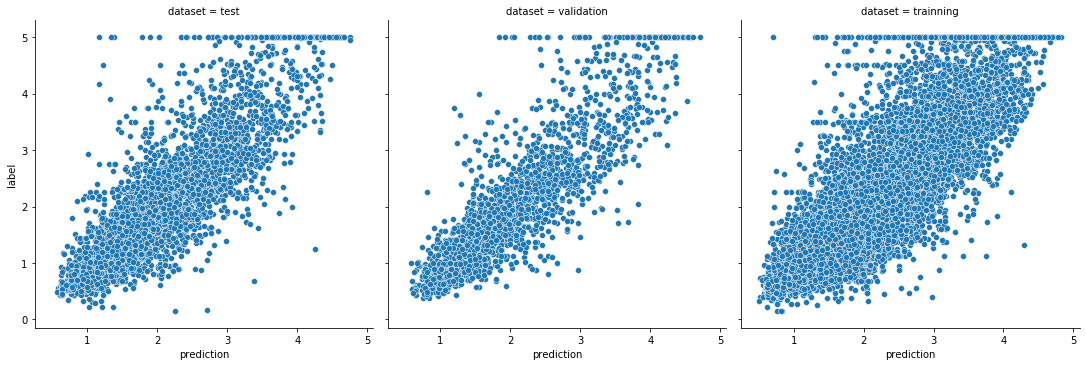

In [48]:
predictions = []
predictions += [(test_set, x,y) for (x,y) in  zip(test_predictions, test_df[target_column_name].tolist())]
predictions += [(validation_set, x,y) for (x,y) in  zip(validation_predictions, validation_df[target_column_name].tolist())]
predictions += [(trainning_set, x,y) for (x,y) in  zip(trainning_predictions, train_df[target_column_name].tolist())]

predictions_df = pd.DataFrame(predictions, columns = [dataset, prediction, label])


visualizer.plot_predictions(predictions_df, prediction, label, dataset)